In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128, 128))
            images.append(img)
    return images, [label] * len(images)

In [3]:
import os
from tensorflow.keras.utils import to_categorical
import cv2
data_dir = r"C:\Users\Shubhankar\Downloads\archive (3)\Alzheimer_MRI_4_classes_dataset"
folders = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
labels = {'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}

all_images = []
all_labels = []
for folder in folders:
    images, label_list = load_images_from_folder(os.path.join(data_dir, folder), labels[folder])
    all_images.extend(images)
    all_labels.extend(label_list)

all_images = np.array(all_images).reshape(-1, 128, 128, 1) / 255.0
all_labels = to_categorical(all_labels, num_classes=4)

data_augmentation = ImageDataGenerator(
    width_shift_range=0.05,  
    height_shift_range=0.05, 
    zoom_range=0.05,         
    horizontal_flip=True,   
    fill_mode='nearest'
)

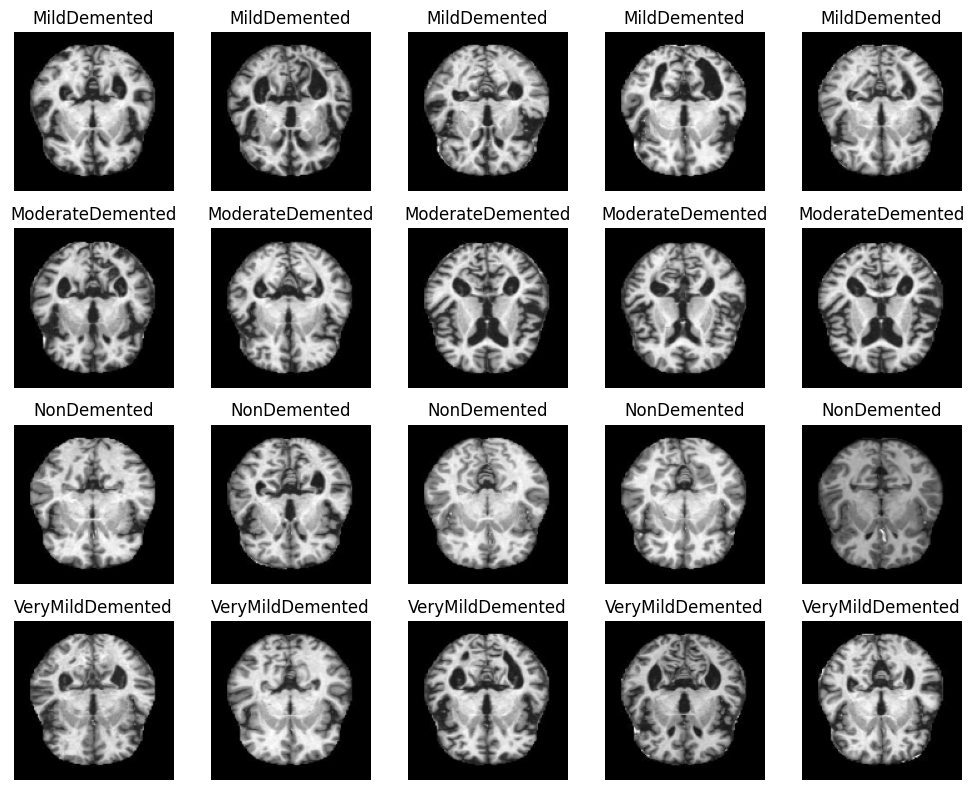

In [4]:
def display_images(images, labels, class_names, num_images=5):
    fig, axes = plt.subplots(nrows=len(class_names), ncols=num_images, figsize=(10, 2 * len(class_names)))
    for i, class_name in enumerate(class_names):
        class_images = [img for img, label in zip(images, labels) if np.argmax(label) == i]
        for j in range(num_images):
            if j < len(class_images):
                ax = axes[i, j]
                ax.imshow(class_images[j].squeeze(), cmap='gray')
                ax.set_title(class_name)
                ax.axis('off')
            else:
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
display_images(all_images, all_labels, class_names, num_images=5)

In [5]:
from sklearn.model_selection import StratifiedKFold

In [6]:
fold_results = {
    'accuracy': [],
    'loss': [],
    'confusion_matrices': [],
    'history': []
}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
for train_index, val_index in kf.split(all_images, np.argmax(all_labels, axis=1)):
    X_train, X_val = all_images[train_index], all_images[val_index]
    y_train, y_val = all_labels[train_index], all_labels[val_index]

    train_generator = data_augmentation.flow(X_train, y_train, batch_size=32)

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    print(f'Training for fold {fold_no}...')
    history = model.fit(
        train_generator,
        epochs=150, 
        validation_data=(X_val, y_val),
        steps_per_epoch=len(X_train) // 32
    )
    fold_results['history'].append(history)

    scores = model.evaluate(X_val, y_val, verbose=0)
    fold_results['accuracy'].append(scores[1])
    fold_results['loss'].append(scores[0])

    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)
    cm = confusion_matrix(y_true, y_pred_classes)
    fold_results['confusion_matrices'].append(cm)

    print(f'Confusion Matrix for fold {fold_no}:')
    print(cm)

    fold_no += 1

c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training for fold 1...
Epoch 1/150


c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - accuracy: 0.4703 - loss: 1.1071 - val_accuracy: 0.5367 - val_loss: 0.9615
Epoch 2/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.5221 - loss: 0.9940 - val_accuracy: 0.5516 - val_loss: 0.9305
Epoch 3/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.5381 - loss: 0.9447 - val_accuracy: 0.5750 - val_loss: 0.8963
Epoch 4/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 99ms/step - accuracy: 0.5629 - loss: 0.9134 - val_accuracy: 0.5805 - val_loss: 0.8686
Epoch 5/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.5682 - loss: 0.8981 - val_accuracy: 0.5664 - val_loss: 0.8865
Epoch 6/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 98ms/step - accuracy: 0.5524 - loss: 0.8989 - val_accuracy: 0.5859 - val_loss: 0.8438
Epoch 7/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - accuracy: 0.5793 - loss: 0.8833 - val_accuracy: 0.5867 - val_loss: 0.8324
Epoch 8/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 16s 101ms/step - accuracy: 0.5600 - loss: 0.8767 - v

c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.4597 - loss: 1.0843 - val_accuracy: 0.5008 - val_loss: 1.0623
Epoch 2/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.5158 - loss: 0.9754 - val_accuracy: 0.5445 - val_loss: 0.9666
Epoch 3/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.5552 - loss: 0.9378 - val_accuracy: 0.5633 - val_loss: 0.8840
Epoch 4/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.5655 - loss: 0.9039 - val_accuracy: 0.5664 - val_loss: 0.8950
Epoch 5/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.5504 - loss: 0.9190 - val_accuracy: 0.5594 - val_loss: 0.8673
Epoch 6/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.5582 - loss: 0.8889 - val_accuracy: 0.5680 - val_loss: 0.8795
Epoch 7/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.5541 - loss: 0.9045 - val_accuracy: 0.5672 - val_loss: 0.8570
Epoch 8/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5881 - loss: 0.8459 - val_

c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.4766 - loss: 1.0784 - val_accuracy: 0.5484 - val_loss: 0.9581
Epoch 2/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.5207 - loss: 0.9918 - val_accuracy: 0.5617 - val_loss: 0.9230
Epoch 3/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.5631 - loss: 0.9269 - val_accuracy: 0.5719 - val_loss: 0.9106
Epoch 4/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.5589 - loss: 0.9090 - val_accuracy: 0.5570 - val_loss: 0.9169
Epoch 5/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 76ms/step - accuracy: 0.5649 - loss: 0.8914 - val_accuracy: 0.5766 - val_loss: 0.8782
Epoch 6/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - accuracy: 0.5467 - loss: 0.8990 - val_accuracy: 0.5727 - val_loss: 0.8674
Epoch 7/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.5808 - loss: 0.8652 - val_accuracy: 0.5984 - val_loss: 0.8658
Epoch 8/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.5836 - loss: 0.8411 - val_

c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 91ms/step - accuracy: 0.4568 - loss: 1.1070 - val_accuracy: 0.5711 - val_loss: 0.9310
Epoch 2/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.5259 - loss: 0.9686 - val_accuracy: 0.5758 - val_loss: 0.9056
Epoch 3/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.5620 - loss: 0.9423 - val_accuracy: 0.5727 - val_loss: 0.8803
Epoch 4/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.5503 - loss: 0.9323 - val_accuracy: 0.5734 - val_loss: 0.8788
Epoch 5/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.5482 - loss: 0.9189 - val_accuracy: 0.5703 - val_loss: 0.8794
Epoch 6/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.5850 - loss: 0.8821 - val_accuracy: 0.5891 - val_loss: 0.8466
Epoch 7/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 90ms/step - accuracy: 0.5720 - loss: 0.9021 - val_accuracy: 0.5992 - val_loss: 0.8356
Epoch 8/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 89ms/step - accuracy: 0.5571 - loss: 0.8889 - val_

c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\Shubhankar\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Training for fold 5...
Epoch 1/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - accuracy: 0.4490 - loss: 1.0813 - val_accuracy: 0.5367 - val_loss: 0.9734
Epoch 2/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.5374 - loss: 0.9631 - val_accuracy: 0.5813 - val_loss: 0.8937
Epoch 3/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.5604 - loss: 0.9153 - val_accuracy: 0.5453 - val_loss: 0.8814
Epoch 4/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.5673 - loss: 0.9065 - val_accuracy: 0.5898 - val_loss: 0.8576
Epoch 5/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.5656 - loss: 0.9028 - val_accuracy: 0.6070 - val_loss: 0.8384
Epoch 6/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 88ms/step - accuracy: 0.5802 - loss: 0.8815 - val_accuracy: 0.6180 - val_loss: 0.8398
Epoch 7/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.5872 - loss: 0.8769 - val_accuracy: 0.6133 - val_loss: 0.8313
Epoch 8/150
160/160 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - acc

In [7]:
print("\nCross-Validation Results Summary:")
avg_accuracy = np.mean(fold_results['accuracy'])
avg_loss = np.mean(fold_results['loss'])
print(f"Average Accuracy: {avg_accuracy*100:.2f}%")
print(f"Average Loss: {avg_loss:.4f}")


Cross-Validation Results Summary:
Average Accuracy: 97.13%
Average Loss: 0.0940


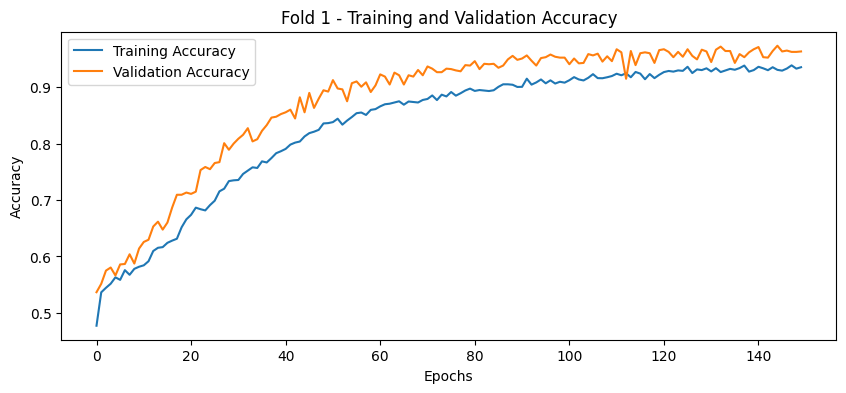

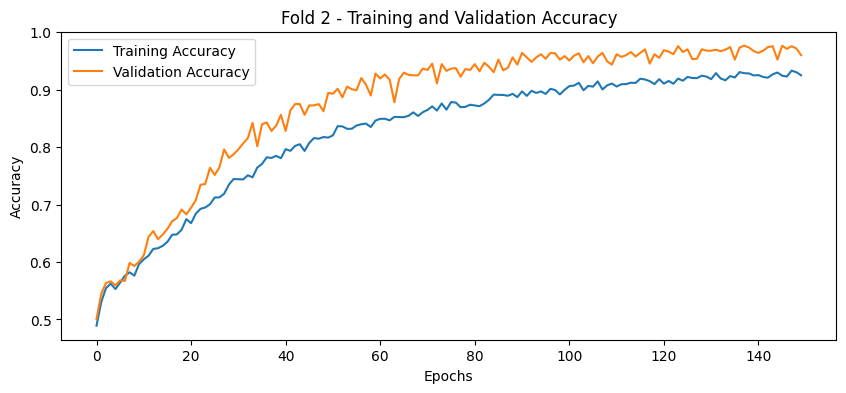

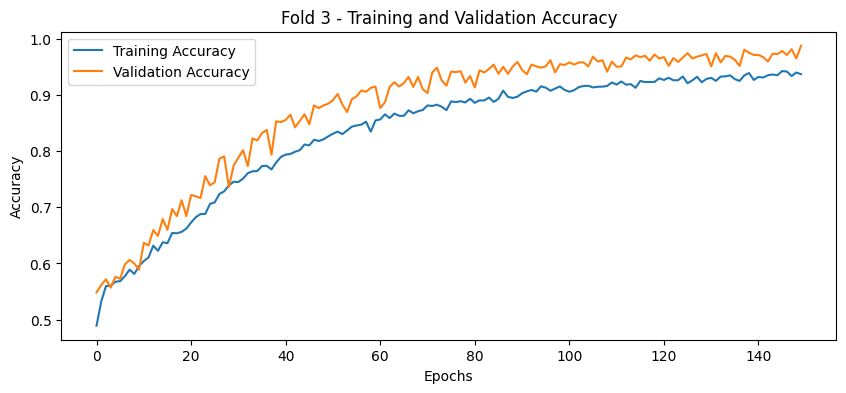

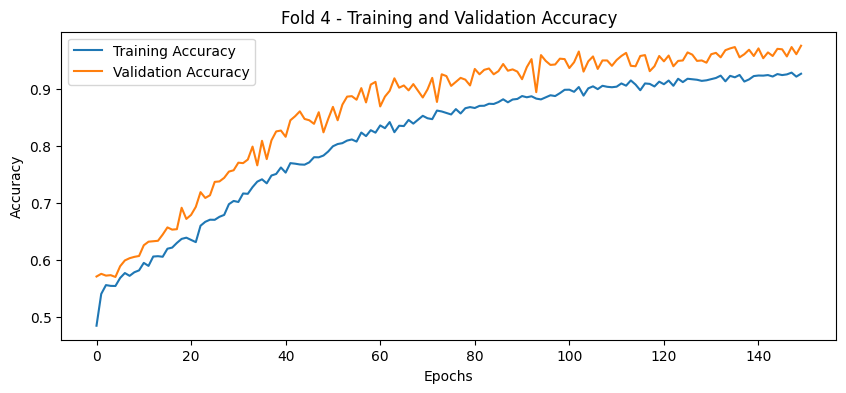

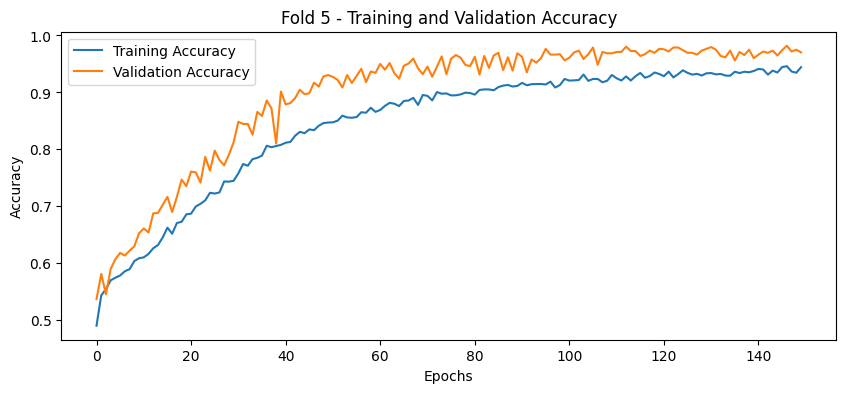

In [8]:
for i, history in enumerate(fold_results['history'], 1):
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {i} - Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

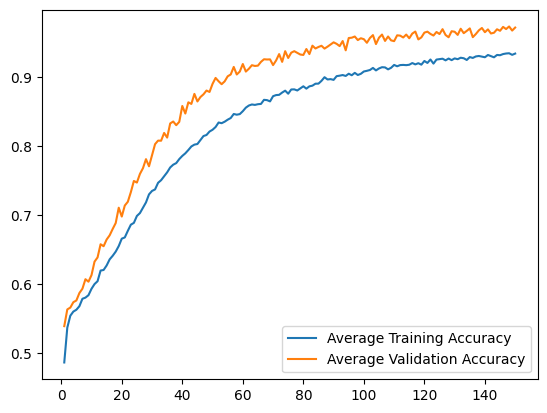

In [9]:
avg_train_acc = np.mean([h.history['accuracy'] for h in fold_results['history']], axis=0)
avg_val_acc = np.mean([h.history['val_accuracy'] for h in fold_results['history']], axis=0)

epochs = range(1, len(avg_train_acc) + 1)
plt.plot(epochs, avg_train_acc, label='Average Training Accuracy')
plt.plot(epochs, avg_val_acc, label='Average Validation Accuracy')
plt.legend()
plt.show()

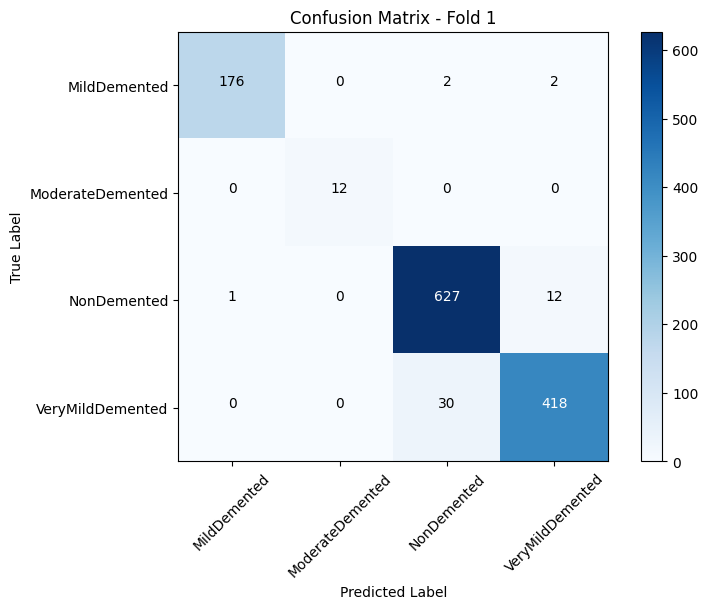

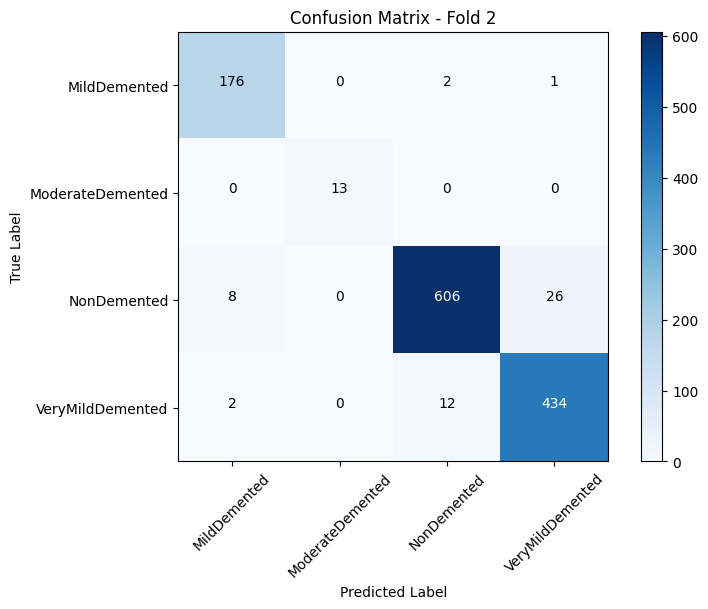

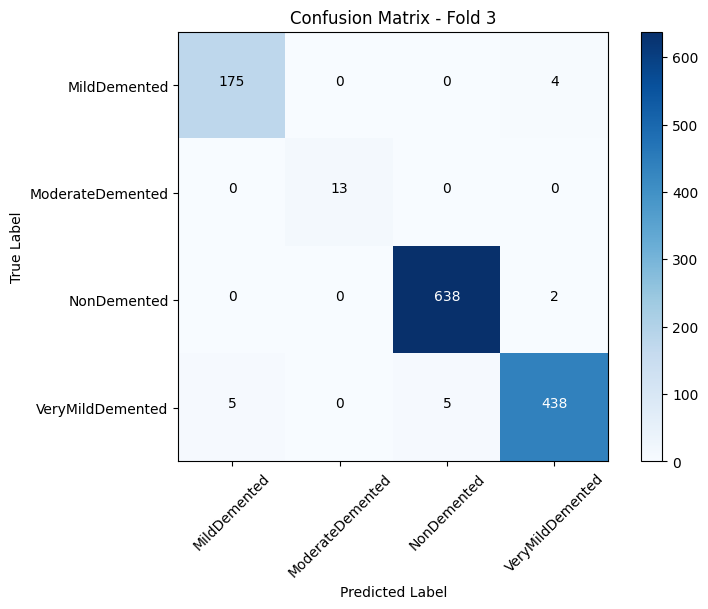

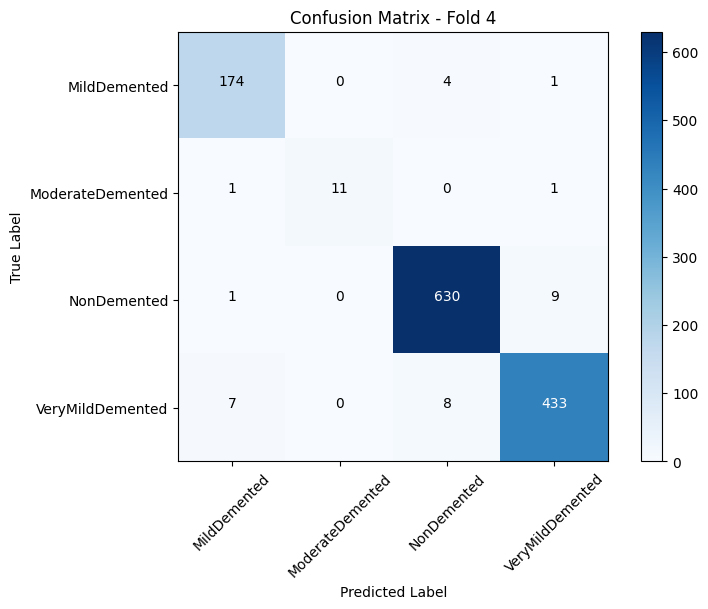

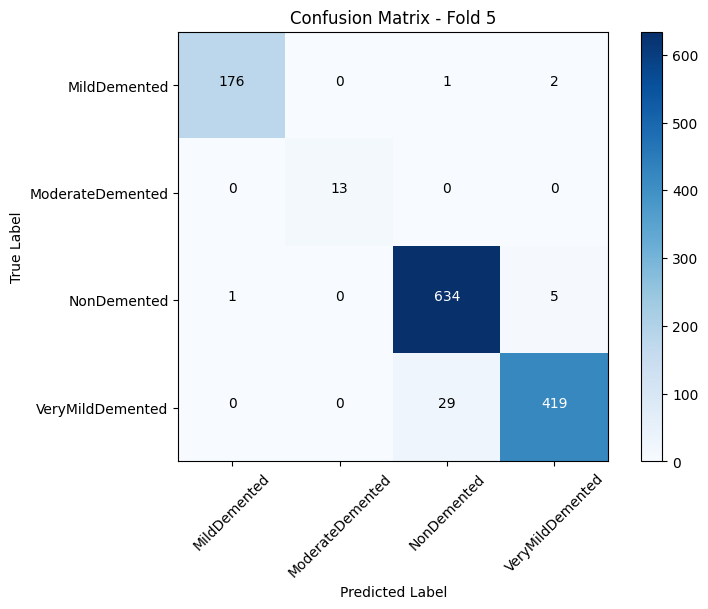

In [10]:
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

class_names = folders
for i, cm in enumerate(fold_results['confusion_matrices'], 1):
    plot_confusion_matrix(cm, class_names, title=f'Confusion Matrix - Fold {i}')

In [14]:
model.save('cnnalzehimermodel.keras')

In [15]:
def test_image(img_path, model):
    class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

    # Read image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("❌ Image not found!")
        return
    resized_img = cv2.resize(img, (128, 128)) / 255.0
    input_img = resized_img.reshape(1, 128, 128, 1)

    # Prediction
    pred = model.predict(input_img)[0]
    pred_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100

    # Show image name
    image_name = os.path.basename(img_path)
    print(f"🖼️ Image: {image_name}")
    print(f"✅ Predicted Class: {pred_class}")
    print(f"📊 Confidence: {confidence:.2f}%")

    # Display image and prediction
    plt.figure(figsize=(10, 4))

    # Show test image
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Test Image\n({image_name})")
    plt.axis('off')

    # Show prediction confidence chart
    plt.subplot(1, 2, 2)
    sns.barplot(x=class_names, y=pred)
    plt.title("Confidence Levels")
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step
🖼️ Image: moderateDem24.jpg
✅ Predicted Class: ModerateDemented
📊 Confidence: 99.96%


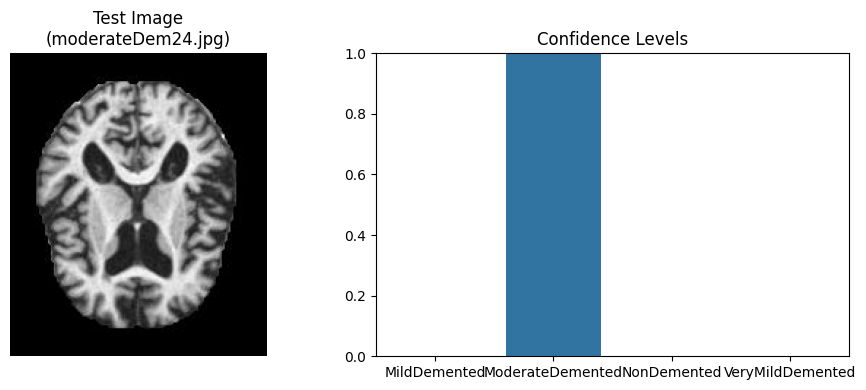

In [ ]:
# test image path
test_image_path= r"C:\Users\Shubhankar\Downloads\Alzheimers disease dataset\Alzheimers disease dataset\Alzheimer's dataset\OriginalDataset\ModerateDemented\moderateDem24.jpg"
test_image(test_image_path, model)
